In [1]:
%%writefile APGTF.py
import ctypes
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.ctypeslib import ndpointer


class DoubleArrayType:
    """data type convertor for c function arguments"""
    def from_param(self,param): # called by ctypes
        typename = type(param).__name__
        if hasattr(self,'from_'+typename):
            return getattr(self,'from_'+typename)(param)
        elif isinstance(param,ctypes.Array):
            return param
        else:
            raise TypeError("Can't convert {}".format(typename))

    def from_array(self,param):
        if param.typecode != 'd':
            raise TypeError('must be an array of doubles')
        ptr,_ = param.buffer_info()
        return ctypes.cast(ptr,ctypes.POINTER(ctypes.c_double))

    def from_list(self,param):
        val = ((ctypes.c_double*len(param)))(*param)
        return val

    from_tuple = from_list

    def from_ndarray(self,param):
        return param.ctypes.data_as(ctypes.POINTER(ctypes.c_double))


class APGTF:
    """python interface for all-pole gammatone filters wrote using C"""
    def __init__(self,fs,low_cf=None,high_cf=None,low_freq=None,high_freq=None,N_band=1):
        """
        Args:
            fs: sample frequency
            low_cf,high_cf: the lowest and highest center frequency
            low_freq,high_freq: the lowest and highest cutoff frequency
            N_band: frequency bands number
        """
        # args check
        if low_cf is None:
            if low_freq is not None:
                # set low_freq as the lowest cutoff frequency
                low_cf = (2*low_freq+24.7)/(2-24.7*4.37/1000)
            else:
                raise Exception('neither low_cf or low_freq is specified')
        if high_cf is None:
            if high_freq is not None:
                # make high_freq as the highest cutoff frequency
                high_cf = (2*high_freq-24.7)/(2+24.7*4.37/1000)
            else:
                raise Exception('neither high_cf or high_freq is specified')

        cfs = self.divide_freq_space(low_freq=low_cf,high_freq=high_cf,N=N_band)# center frequency
        bs = self.cal_ERB(cfs) # bandwidth
        if (cfs is None) or (bs is None):
            raise Exception('cfs and bs uninitlaized')
            
        self.fs = fs
        self.cfs = cfs
        self.bs = bs
        self.N_band = N_band
            
        # load shared library
        self.lib_path = os.path.join(os.getcwd(),'libAPGTF.so')
        self.load_lib()
        
    
    def load_lib(self):
        if not os.path.exists(self.lib_path):
            raise Exception('missing libAPGF.so')
        _cmodel = ctypes.cdll.LoadLibrary(self.lib_path)
        self._gt_filter = _cmodel.APGTF
        DoubleArray = DoubleArrayType()
        self._gt_filter.argtypes = (DoubleArray,ctypes.c_int,ctypes.c_int,
                                    DoubleArray,DoubleArray,ctypes.c_int,ctypes.c_int)
        

    
    
    def divide_freq_space(self,low_freq,high_freq,N,divide_type='ERB'):
        """ Divide frequency range (low_freq~high_freq) equally in erb scale(default)
        Args: 
            low_freq: low bound of frequency range
            high_freq: high bound of frequency range
            N: segments number frequency range to be divided
            divide_type: default to ERB
        """
        if divide_type is 'ERB':
            if N == 1:
                return np.asarray(low_freq,dtype=np.float).reshape(1,)
            low_erb = self.Hz2ERBscal(low_freq)
            high_erb = self.Hz2ERBscal(high_freq)
            erb_elem = (high_erb-low_erb)/(N-1)
            f = self.ERBscal2Hz(low_erb+erb_elem*np.arange(N))
        else:
            raise Exception('unsupport Divide type')
        return f

    
    def Hz2ERBscal(self,freq):
        """convert Hz to ERB scale"""
        return 21.4*np.log10(4.37*freq/1e3+1)

    def ERBscal2Hz(self,erb_num):
        """convert ERB scale to Hz"""
        return (10**(erb_num/21.4)-1)/4.37*1e3

    def cal_ERB(self,cf):
        """calculate the ERB(Hz) of given center frequency based on equation given by Glasberg and Moore
        Args
            cf: center frequency Hz
        """
        return 24.7*(4.37*cf/1000+1.0)
        
        
    def filter_x(self,x,is_aligned=0):
        """filter input signal
        Args:
            x: signal with shape of [x_len,N_chann], if x only has single dimension, 
               N_chann will be added as 1
            is_aligned: aligned peaks of Gammatone filter impulse response
        Returns:
            fitler result with the shape of [N_band,x_len,N_chann]
        """
        
        if not isinstance(x,np.ndarray):
            raise Exception()
        if len(x.shape) > 2:
            raise Exception('two many dimensions for x')
        
        x_len = x.shape[0]
        if len(x.shape) == 1:    
            x.shape = (x_len,1)
        N_chann = x.shape[1]
            
        x_filtered = np.zeros((self.N_band,x_len,N_chann))
        self._gt_filter.restype = ndpointer(dtype=ctypes.c_double,
                                            shape=(self.N_band,x.shape[0]))
        
        for chann_i in range(N_chann): 
            x_chann = np.copy(x[:,chann_i])# data in slice are not stored in continue memmory
            x_filtered[:,:,chann_i] =  self._gt_filter(x_chann, x_chann.shape[0],
                                                       self.fs, self.cfs,self.bs,
                                                       self.N_band,is_aligned)
        return np.squeeze(x_filtered)
        
    
    def cal_delay_gain(self,is_plot=False):
        """ calculate delay and center-frequency gain of gammatone filter
        before alignment and gain-normalization
        Returns:
            [delays,gains]
            the delays and gains at center freuqency of each frequency band
            delays: in milisecond
        """
        k = np.exp(-2*np.pi/self.fs*self.bs);
        Q = np.divide(self.cfs,self.bs) # quality of filter
        
        temp1 = 8*Q*(1-4*Q**2)
        temp2 = np.multiply(Q**2,Q*(16*Q**2-24))
        phi_delay = np.arctan(np.divide(temp1,temp2+2))-np.arctan(np.divide(temp1,temp2+1));
        delays = phi_delay/(2*np.pi)*1e3
        
        correct_factor = np.sqrt(((temp2+1)**2+temp1**2)/((temp2+2)**2+temp1**2)) 
        gains = 10*np.log10(3/(2*np.pi*self.bs))*correct_factor
        
        if is_plot:
            fig = plt.figure(figsize=[8,3],dpi=100)
            axs = fig.subplots(1,2)
            axs[0].plot(self.cfs,delays); 
            axs[0].set_xlabel('Frquency(Hz)'); axs[0].set_ylabel('Delay(ms)');
            axs[1].plot(self.cfs,gains); 
            axs[1].set_xlabel('Frquency(Hz)'); axs[1].set_ylabel('Gain(dB)');
            plt.tight_layout()
            
        return [delays,gains]
        
    def plot_ir_spec(self,ir,fs=None,fig=None,is_auto_scale=True,title='ir'):
        """plot the waveform and spectrum of given impulse response
        Args:
            ir: impulse response
            fs: sample frequency,use self.fs as default
            fig: handle of matplotlib figure, if not given, not figure will be created
            is_auto_scale: auto limit the x-axis range to make nonzeros part stick out
            title: title for ir waveform sub-panel
        """
        
        if fs == None:
            fs = self.fs
            
        ir_len = ir.shape[0]
        N_fft = ir_len
        N_fft_half = np.int(N_fft/2)
        
        spec = np.abs(np.fft.fft(ir,N_fft,axis=0))[:N_fft_half,:]        

        time_ticks = np.arange(ir_len)/self.fs
        freq_ticks = np.arange(N_fft_half)/N_fft*self.fs
        
        if fig is None:
            fig = plt.figure(figsize=[8,3],dpi=100)
        
        axs = fig.subplots(1,2)
        axs[0].plot(time_ticks,ir,linewidth=2) 
        axs[0].set_xlabel('Time(s)'); axs[0].set_title(title)
        x_lim_max = time_ticks[np.max(np.nonzero(np.max(ir,axis=1)>np.max(ir)*1e-5)[0])]
        axs[0].set_xlim([0,x_lim_max]) 
        
        axs[1].plot(freq_ticks,spec,linewidth=2); 
        axs[1].set_xlabel('Frequency(Hz)'); axs[1].set_title('spectrum')
        plt.tight_layout()
        
        
    def plot_gtf(self,ir_duration=1,fig=None):
        """plot the impulse response and spectrum of gammatone filters
        both not aligned and aligned
        Args:
            ir_duration: time duration(in second) of impulse response to be plot
        """
        
        ir_len = np.int(self.fs*ir_duration)
        # impulse stimuli
        x = np.zeros((ir_len,1))
        x[100] = 1# the spike
        
        # gain and delay at center frequency before aligments and gain-normalized
        self.cal_delay_gain(is_plot=True)
        
        # impulse response 
        # not aligned
        ir = self.filter_x(x,is_aligned=0);
        self.plot_ir_spec(ir.T,fig=fig,title='IR(not aligned)') 
#         plt.savefig('example/ir_not_aligned.png')
        # aligned
        ir_algined = self.filter_x(x,is_aligned=1);
        self.plot_ir_spec(ir_algined.T,fig=fig,title='IR(aligned)') 
#         plt.savefig('example/ir_aligned.png')
        return [ir,ir_algined]


Overwriting APGTF.py


In [2]:
# %mkdir example

In [3]:
import APGTF
from imp import reload
reload(APGTF)

<module 'APGTF' from '/home/st/Work_Space/module_st/Gammatone-filters/APGTF.py'>

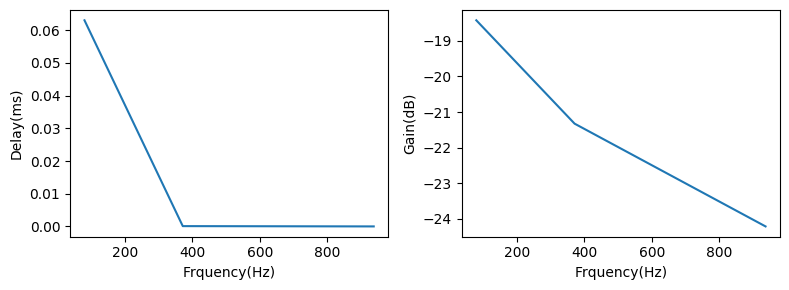

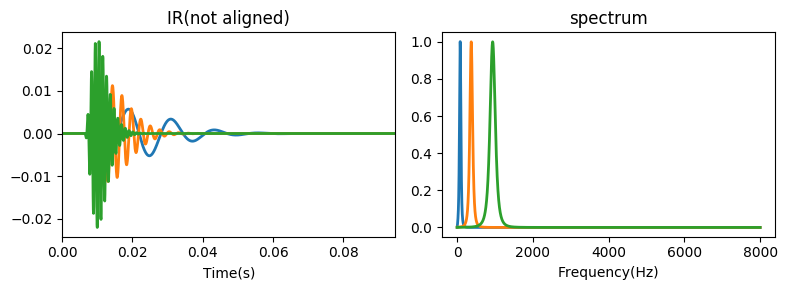

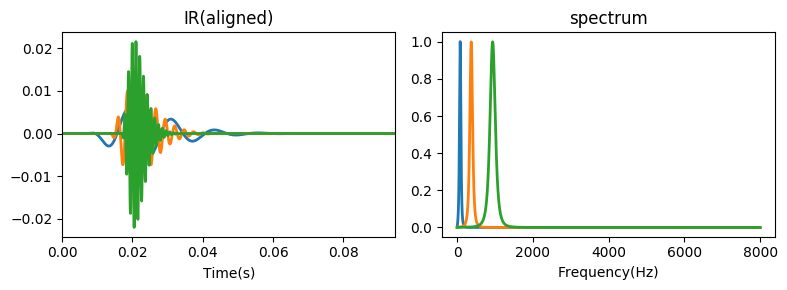

In [4]:
gtf = APGTF.APGTF(fs=16000,low_cf=80,high_freq=1000,N_band=3)
ir = gtf.plot_gtf()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
x = np.zeros((1000,2))
x[10,0] = 10
x[100,1] = 100

In [7]:
x_filtered = gtf.filter_x(x,is_aligned=0)

In [8]:
x_filtered.shape

(3, 1000, 2)

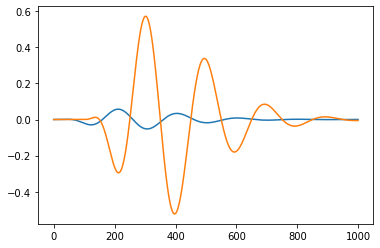

In [9]:
plt.plot(x_filtered[0])